In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
train.rename(str.lower, axis='columns', inplace=True)
train.set_index('passengerid', inplace=True)
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration and Visualization

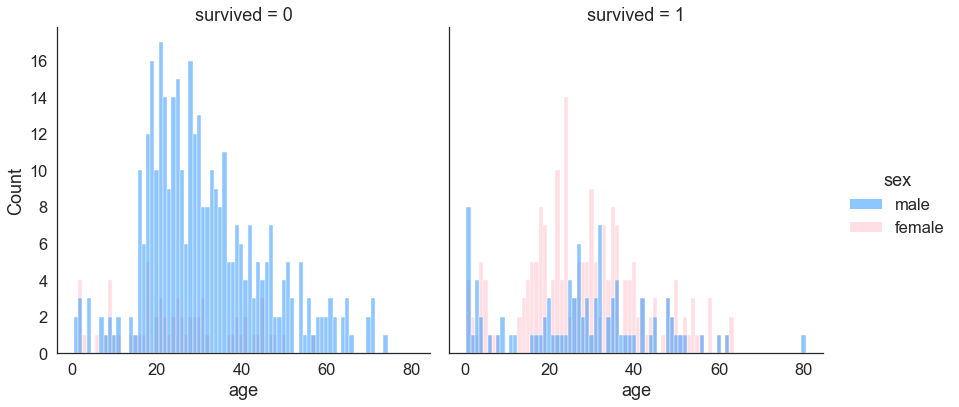

In [2]:
sns.set_theme(style='white', palette=['dodgerblue', 'pink'], font_scale=1.5)

plt1 = sns.displot(data=train, x='age', hue='sex', col='survived', binwidth=1, height=6)

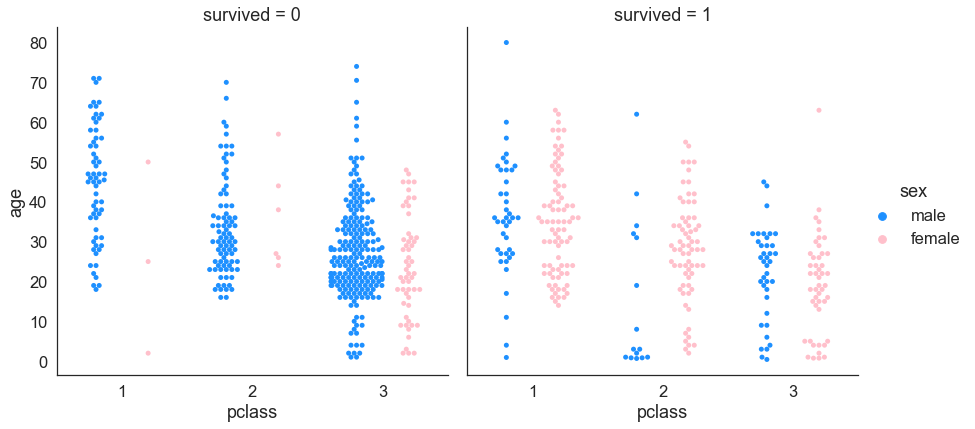

In [3]:
sns.catplot(data=train, hue='sex', y='age', col='survived', x='pclass', 
            kind='swarm', height=6, split=True)
plt.show()

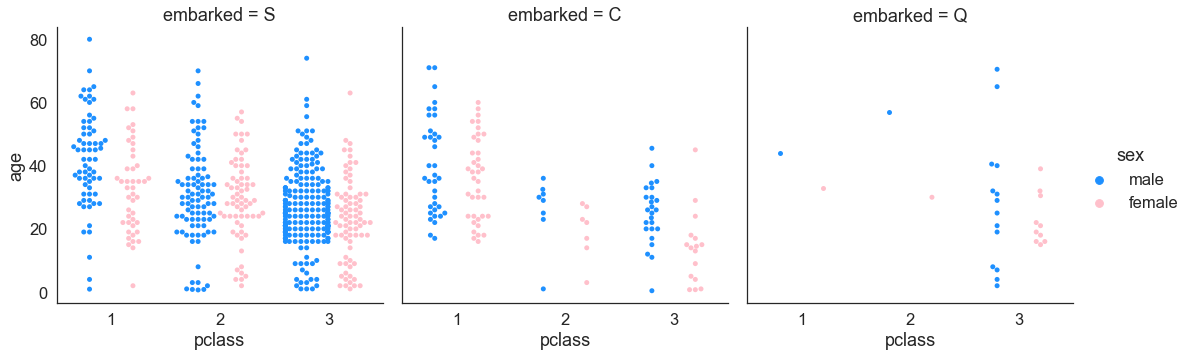

In [4]:
sns.catplot(data=train, hue='sex', y='age', col='embarked', x='pclass', 
            kind='swarm', height=5, split=True)
plt.show()

### Observations:

1. Class, age and sex are clearly important to chances of survival.
2. There are very few children in 1st class.
3. Children have a better shot at survival, but some children still die in 3rd class, and one in 1st class too.
4. Almost passengers that embark from Q are in 3rd class, C has the highest proportion of first class passengers

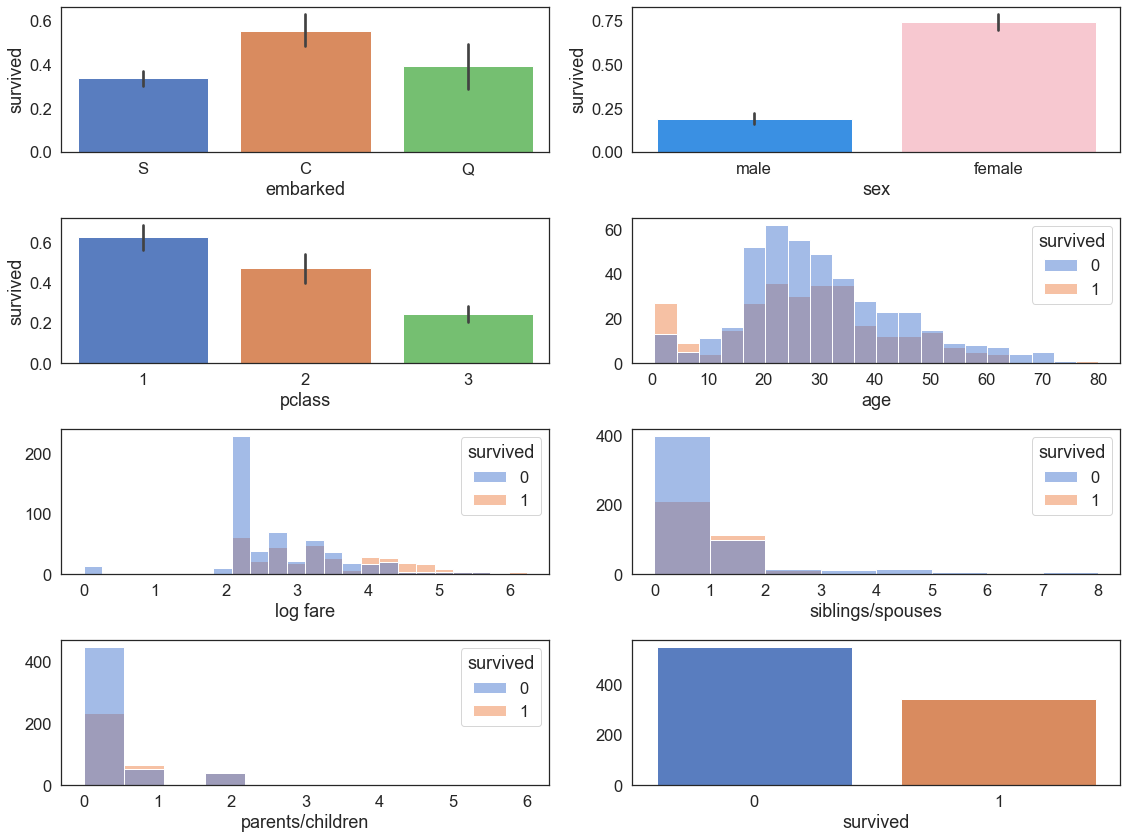

In [5]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(421)
sns.barplot(data=train, x='embarked', y='survived', palette='muted')
ax2 = fig.add_subplot(422)
sns.barplot(data=train, x='sex', y='survived')
ax3 = fig.add_subplot(423)
sns.barplot(data=train, x='pclass', y='survived', palette='muted')
ax4 = fig.add_subplot(424)
sns.histplot(data=train, x='age', hue='survived', palette='muted')
ax4.set_ylabel('')
ax5 = fig.add_subplot(425)
ax5.set_xlabel('log fare')
sns.histplot(data=train, x=np.log(train.fare + 1), hue='survived', palette='muted')
ax5.set_ylabel('')
ax6 = fig.add_subplot(426)
ax6.set_xlabel('siblings/spouses')
sns.histplot(data=train, x='sibsp', hue='survived', binwidth=1, palette='muted')
ax6.set_ylabel('')
ax7 = fig.add_subplot(427)
sns.histplot(data=train, x='parch', hue='survived', palette='muted')
ax7.set_ylabel('')
ax7.set_xlabel('parents/children')
ax8 = fig.add_subplot(428)
sns.countplot(data=train, x='survived', palette='muted')
ax8.set_ylabel('')

plt.tight_layout()
plt.show()

### Observations:

5. There appears to be a better change of survival based on `embarked` but this is could be picking on `pclass` mean differences between groups (Obs. 4)
6. `sex` is very important feature. Women have a much greater chance of survivial.
7. `pclass` is also very important.
8. Younger people especially but perhaps also older people have a better chance of survival.
9. `fare`, which is likeley closely related to `pclass` is important for survival.
10. People with family members appear to fare better, this could have something to do with `age`

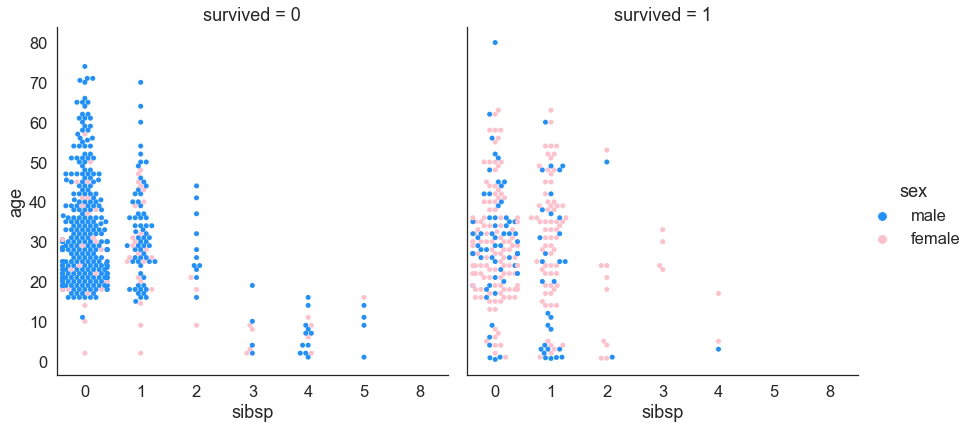

In [6]:
p = sns.catplot(data=train, x='sibsp', col='survived', hue='sex', y='age', kind='swarm', height=6)

### Observations:

11. Higher `sibsp` appears related to being younger, as I would expect
12. A lot of children, surprisingly, die when `sibsp` is higher, that is, only-children appear to fare better. This, in part, is probably related to `pclass`, as I mentioned in Obs. 2, there are almost no children in 1st class.

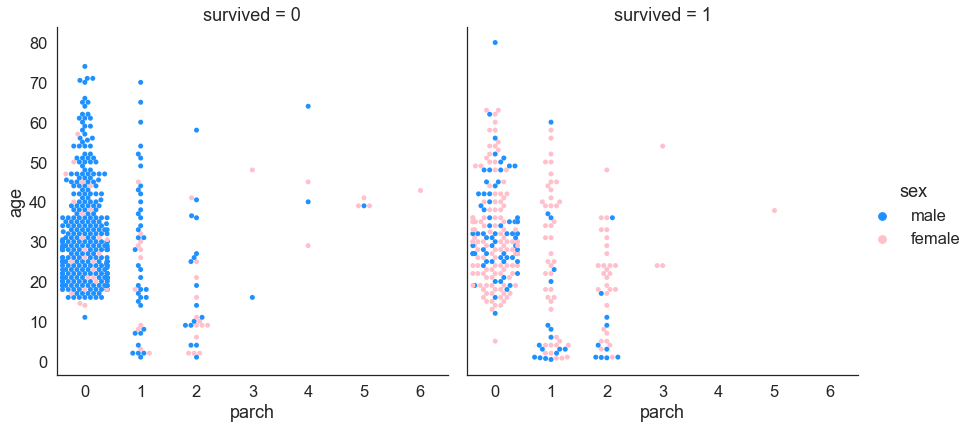

In [7]:
p = sns.catplot(data=train, x='parch', col='survived', hue='sex', y='age', kind='swarm', height=6)

### Observations:

13. Obviously you can only be a child if `parch` > 0, well, there does appear to be a 10 year-old with no parents.
14. Other than the fact that children are more likely to survive and the obs. above, hard to tell if `parch` is useful from this plot. Very few men with children survive but I cannot tell if it significant necessarily.

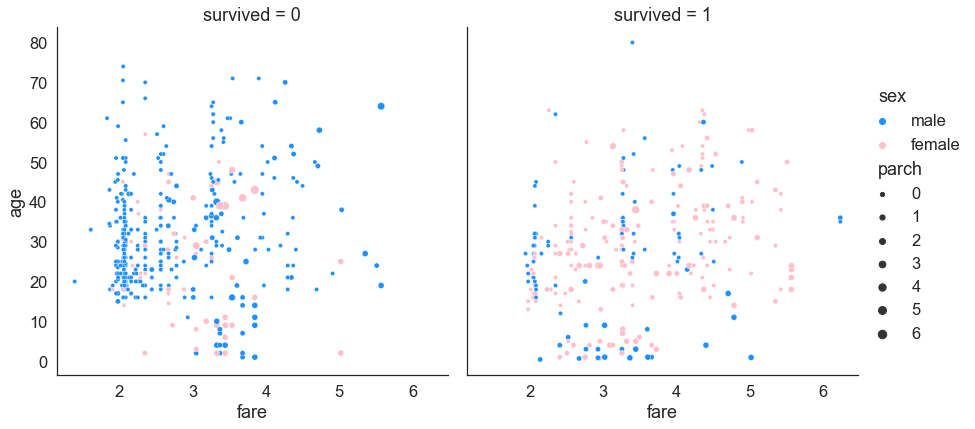

In [8]:
p = sns.relplot(data=train, x=np.log(train.fare), y='age', col='survived', hue='sex', size='parch', height=6)

### Observations

15. `fare` doesn't perfectly correspond with class. Some people got a bargain, but otherwise pretty stratified.
16. The people with low fares that do survive tend to be children or women, as we'd expect already.
17. There does appear to be a cluster of low-fare surviving men, from about 20-30, but this could just have more to do with missing `age` data as well.

In [9]:
train.query('19 < age < 31 & sex == "male" & survived == 1 & pclass == 3')

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S
128,1,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S
147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
208,1,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,NaN,C
268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S
392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S
456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C


### Observations:

18. Of the men in their 20's and in third class that also survive, only one hase a child. And only three have a spouse. Intuitively, I would think if you are a man with a wife and children, you probably wouldn't put up much of a fight to be on one of the boats because you want to make sure you wife and children have a spot, if you're alone I think you have more of an incentive to be, well, selfish and perhaps more able to justify since you are by yourself.

## Correlation between features (Pearson's $\rho$)

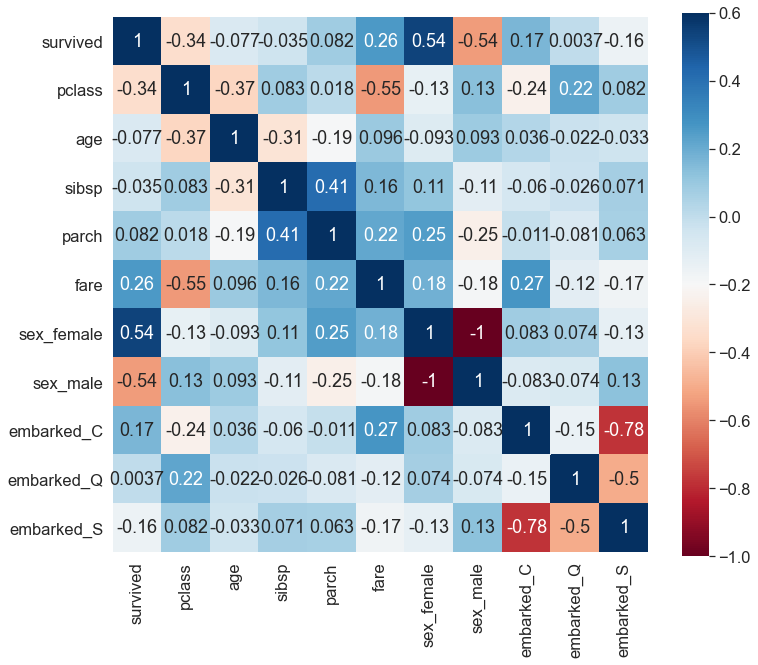

In [10]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(pd.get_dummies(train.drop(columns=['name', 'ticket', 'cabin'])).corr(method='pearson'), square=True,
            vmax=.6, annot=True, cmap="RdBu")
plt.show()

## Missing data

In [11]:
missing = pd.DataFrame(train.isna().sum()).rename(columns={0: 'missing'})
missing[missing.missing != 0]

,missing
age,177
cabin,687
embarked,2


In [12]:
# missing by class
cols = ['age', 'cabin', 'embarked']
train.drop('pclass', 1)[cols].isna().groupby(train.pclass).mean().style.background_gradient(cmap='RdBu', vmin=0,vmax=1)

,age,cabin,embarked
pclass,,,
1,0.138889,0.185185,0.009259
2,0.059783,0.913043,0.000000
3,0.276986,0.975560,0.000000


### Observations:

19. We are missing a lot of `cabin` data and also about 20% of `age` data. `cabin` may not be all that useful, but `age` definitely is based on the exploration above. 
20. It appears that we are more likely to be missing data for `age` and `cabin` for those in 3rd class.

In [13]:
# missing by age %
train.drop('sex', 1)[cols].isna().groupby(train.sex).mean().style.background_gradient(cmap='RdBu', vmin=0,vmax=1)

,age,cabin,embarked
sex,,,
female,0.168790,0.691083,0.006369
male,0.214905,0.814558,0.000000


In [14]:
# missing by embarked %
train.drop('embarked', 1)[['age', 'cabin']].isna().groupby(train.embarked).mean().style.background_gradient(cmap='RdBu', vmin=0,vmax=1)

,age,cabin
embarked,,
C,0.226190,0.589286
Q,0.636364,0.948052
S,0.139752,0.799689


### Observations:

21. A lot of missing data for those embarking from port `Q`, probably related to `pclass` mean differences by port.

In [15]:
# missing by survived %
train.drop('survived', 1)[cols].isna().groupby(train.survived).mean().style.background_gradient(cmap='RdBu', vmin=0,vmax=1)

,age,cabin,embarked
survived,,,
0,0.227687,0.876138,0.000000
1,0.152047,0.602339,0.005848


How should we fill in missing data? We could use some group mean or median. We could also first create features such as title, from `name` and use that as a group.

## Extraicting title from `name` and imputing `age`

In [16]:
train['title'] = train.name.str.split(',').str[1].str.split().str[0]
train.title.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Capt.          1
Lady.          1
Don.           1
Ms.            1
Sir.           1
Jonkheer.      1
Mme.           1
the            1
Name: title, dtype: int64

In [17]:
train.groupby('title').age.agg(['mean', 'count'])#.astype(int).sort_values()

,mean,count
title,,
Capt.,70.000000,1
Col.,58.000000,2
Don.,40.000000,1
Dr.,42.000000,6
Jonkheer.,38.000000,1
Lady.,48.000000,1
Major.,48.500000,2
Master.,4.574167,36
Miss.,21.773973,146


In [18]:
train[train.age.isna()].title.value_counts()

Mr.        119
Miss.       36
Mrs.        17
Master.      4
Dr.          1
Name: title, dtype: int64

In [19]:
train['mean_age_by_title'] = train.groupby('title').age.transform(np.mean)
train.loc[train.age.isna(), 'age'] = train[train.age.isna()].mean_age_by_title
train.groupby('survived').age.agg('mean')

survived
0    30.688211
1    28.256062
Name: age, dtype: float64

## Feature Engineering

In [20]:
train['child'] = (train.age < 13).astype(int)
train['young'] = ((train.age > 12) & (train.age < 31)).astype(int)
train['old'] = (train.age > 49).astype(int)
train['alone'] = ((train.sibsp == 0) & (train.parch == 0)).astype(int)
train['parent'] = ((train.child == 0) & (train.parch > 0)).astype(int)
train['female'] = (train.sex == 'female').astype(int).astype(int)
train['big_family'] = (train.sibsp + train.parch > 3).astype(int)
train['log_fare'] = np.log(train.fare + 1)

## Modeling

### Naive Bayes

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X = train[['pclass', 'old', 'log_fare','young', 'child', 'alone', 'big_family', 'parent', 'female']]
y = train.survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8324022346368715

In [22]:
cross_val_score(gnb, X, y, cv=5).mean()

0.787973134140983

### Support Vector Machine

In [23]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=13)
y_pred = svc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8491620111731844

In [24]:
cross_val_score(svc, X, y, cv=5).mean()

0.8181658401858012

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(ccp_alpha=0.05, random_state=13)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8212290502793296

In [26]:
cross_val_score(dtc, X, y, cv=5).mean()

0.7867365513778168

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=13)
parameters = {'n_estimators': [10, 50, 100, 250, 500, 1000], 'max_depth': np.arange(1,5)}
cv_rfc = GridSearchCV(rfc, parameters)
cv_rfc.fit(X_train, y_train)
print(f'best estimator:\t {cv_rfc.best_estimator_}')
print(f'best score:\t {cv_rfc.best_score_:.2f}')

best estimator:	 RandomForestClassifier(max_depth=4, n_estimators=250, random_state=13)
best score:	 0.82


In [28]:
rfc = RandomForestClassifier(n_estimators=250, max_depth=4, random_state=13)
y_pred = rfc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8491620111731844

In [29]:
cross_val_score(rfc, X, y, cv=5).mean()

0.8215554579122466

### Extra Random Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(bootstrap=True, oob_score=True, n_estimators=250, max_depth=4, random_state=13)
y_pred = etc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8547486033519553

In [31]:
cross_val_score(etc, X, y, cv=5).mean()

0.8349946644906158

### Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=4, random_state=13)
y_pred = gbc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8715083798882681

In [33]:
cross_val_score(gbc, X, y, cv=5).mean()

0.837266963781307

### Adaptive Boosting

In [34]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(learning_rate=0.05)
y_pred = abc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8212290502793296

In [35]:
cross_val_score(abc, X, y, cv=5).mean()

0.7878601468834348

### Multilayer Perceptron

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from itertools import product
mlp = MLPClassifier(solver='adam', random_state=13, alpha=0.01, learning_rate_init=0.001)
parameters = {"hidden_layer_sizes" : list(product(range(2,10), range(2,10)))}
cv_mlp = GridSearchCV(mlp, parameters)
cv_mlp.fit(X_train, y_train)
print(f'best estimator:\t {cv_mlp.best_estimator_}')
print(f'best score:\t {cv_mlp.best_score_:.2f}')

best estimator:	 MLPClassifier(alpha=0.01, hidden_layer_sizes=(6, 2), random_state=13)
best score:	 0.82


In [37]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(6, 2), alpha=0.01, learning_rate_init=0.001,
                   random_state=13)
y_pred = mlp.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8603351955307262

In [38]:
cross_val_score(mlp, X, y, cv=5).mean()

0.8260184545853996

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=5)
y_pred = knc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8324022346368715

In [40]:
cross_val_score(knc, X, y, cv=5).mean()

0.8148327160881299

### Bagging

In [114]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(
    MLPClassifier(solver='adam', random_state=13, 
                  alpha=0.01, learning_rate_init=0.02,
                  hidden_layer_sizes=(6, 2)
                 ),
    oob_score=True
    )
y_pred = bag.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8547486033519553

In [115]:
cross_val_score(bag, X, y, cv=5).mean()

0.8159374803841567

### XGBoost (Best)

In [107]:
import xgboost as xgbd
xgbc = xgb.XGBClassifier(eval_metric='logloss')
parameters = {
    "learning_rate" : np.linspace(start=0.001, stop=0.1, num=10, endpoint=True),
    "max_depth": np.arange(1,4), 
    "n_estimators": [250, 500, 750, 1000, 2000]}
cv_xgbc = GridSearchCV(xgbc, parameters)
cv_xgbc.fit(X_train, y_train)
print(f'best estimator:\t {cv_xgbc.best_estimator_}')
print(f'best score:\t {cv_xgbc.best_score_:.3f}')

best estimator:	 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.023000000000000003,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=750, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
best score:	 0.838


In [108]:
xgbc = xgb.XGBClassifier(learning_rate=0.023, n_estimators=750,
                         max_depth= 3, eval_metric='error')
y_pred = xgbc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.88268156424581

In [109]:
cross_val_score(xgbc, X, y, cv=5).mean()

0.8518674282844767

### Light GB

In [50]:
import lightgbm as lgb
lgbc = lgb.LGBMClassifier()
parameters = {
    "learning_rate" : np.linspace(start=0.001, stop=0.1, num=10, endpoint=True),
    "max_depth": np.arange(1,4), 
    "n_estimators": [250, 500, 750, 1000, 2000]}
cv_lgbc = GridSearchCV(lgbc, parameters)
cv_lgbc.fit(X_train, y_train)
print(f'best estimator:\t {cv_lgbc.best_estimator_}')
print(f'best score:\t {cv_lgbc.best_score_:.3f}')

best estimator:	 LGBMClassifier(learning_rate=0.023000000000000003, max_depth=2,
               n_estimators=1000)
best score:	 0.848


In [51]:
lgbc = lgb.LGBMClassifier(learning_rate=0.023, n_estimators=1000, max_depth=2)
y_pred = lgbc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.88268156424581

In [52]:
cross_val_score(lgbc, X, y, cv=5).mean()

0.8440148138848785

### Voting Classifier

In [166]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(
    estimators=[
        #('mlp', mlp), 
        ('knn', knc),
        #('etc', etc),
        ('svc', svc),
        #('gfc', gbc),
        ('xgbc', xgbc),
        #('lgbc', lgbc),
    ]
    )
vote.fit(X_train,y_train)

y_pred = vote.fit(X_train, y_train).predict(X_test)
accuracy_score(y_pred, y_test)

0.8715083798882681

In [167]:
cross_val_score(vote, X, y, cv=5).mean()

0.8428723871696692

## Prepare submission

In [53]:
test = pd.read_csv('test.csv')
test.rename(str.lower, axis='columns', inplace=True)
test.set_index('passengerid', inplace=True)

test['title'] = test.name.str.split(',').str[1].str.split().str[0]
test[test.age.isna()].title.value_counts()

Mr.        57
Miss.      14
Mrs.       10
Master.     4
Ms.         1
Name: title, dtype: int64

In [54]:
test.loc[(test.age.isna()) & (test.title=='Mr.'), 'age'] = 33
test.loc[(test.age.isna()) & (test.title=='Miss.'), 'age'] = 22
test.loc[(test.age.isna()) & (test.title=='Mrs.'), 'age'] = 36
test.loc[(test.age.isna()) & (test.title=='Master.'), 'age'] = 5
test.loc[(test.age.isna()) & (test.title=='Ms.'), 'age'] = 22

In [55]:
test['child'] = (test.age < 13).astype(int)
test['young'] = ((test.age > 12) & (test.age < 31)).astype(int)
test['old'] = (test.age > 49).astype(int)
test['alone'] = ((test.sibsp == 0) & (test.parch == 0)).astype(int)
test['parent'] = ((test.child == 0) & (test.parch > 0)).astype(int)
test['female'] = (test.sex == 'female').astype(int)
test['big_family'] = (test.sibsp + test.parch > 3).astype(int)
test['log_fare'] = np.log(test.fare + 1)

test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,child,young,old,alone,parent,female,big_family,log_fare
passengerid,,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr.,0,0,0,1,0,0,0,2.178064
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs.,0,0,0,0,0,1,0,2.079442
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr.,0,0,1,1,0,0,0,2.369075
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr.,0,1,0,1,0,0,0,2.268252
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs.,0,1,0,0,1,1,0,2.586824


In [56]:
X_submit = test[['pclass', 'old', 'log_fare','young', 'child', 'alone', 'big_family', 'parent', 'female']]

In [57]:
X_submit.isna().sum()

pclass        0
old           0
log_fare      1
young         0
child         0
alone         0
big_family    0
parent        0
female        0
dtype: int64

In [58]:
X_submit.loc[X_submit.log_fare.isna(), 'log_fare'] = 10

In [110]:
submit = pd.DataFrame(dict(PassengerId=X_submit.index, Survived=xgbc.predict(X_submit)))

In [111]:
submit.to_csv('submit.csv', index=False)

In [64]:
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## Feature Importance

In [150]:
pd.DataFrame(list(zip(X.columns,xgbc.feature_importances_))).sort_values(1, ascending=False)

,0,1
8,female,0.461007
0,pclass,0.194548
6,big_family,0.123419
4,child,0.107501
2,log_fare,0.030507
3,young,0.027605
1,old,0.021160
7,parent,0.020128
5,alone,0.014126


In [158]:
pd.DataFrame(list(zip(X.columns,etc.feature_importances_))).sort_values(1, ascending=False)

,0,1
8,female,0.561024
0,pclass,0.172768
6,big_family,0.066145
4,child,0.060838
5,alone,0.050534
2,log_fare,0.049204
3,young,0.015885
1,old,0.013533
7,parent,0.010069
